In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns        
import matplotlib.pyplot as plt 
import glob
import os
import time    
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler, Normalizer
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_sample_weight
from scipy import sparse


In [2]:

def predict_and_get_auc(model, X_train, X_test, y_train, y_test):
    # Predicciones en probas
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob  = model.predict_proba(X_test)[:, 1]

    # AUC train
    fpr, tpr, _ = roc_curve(y_train, y_train_prob)
    print("AUC train =", round(auc(fpr, tpr), 2))

    # AUC test
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    print("AUC test  =", round(auc(fpr, tpr), 2))

In [3]:
df_1=pd.read_parquet(
    "/Users/danielmunoz/Documents/EDUCACION/DATA_ANALIST/CURSOS/TFM/DATA/PROCESSED/df_YouTube_2025TFM.parquet")

In [4]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19154 entries, 0 to 19153
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   video_id                19154 non-null  object 
 1   title                   19154 non-null  object 
 2   description             15337 non-null  object 
 3   published_at            19154 non-null  object 
 4   duration_minutes        19154 non-null  float64
 5   definition              19154 non-null  int64  
 6   licensed_content        19154 non-null  Int64  
 7   has_caption             19154 non-null  Int64  
 8   category_id             19154 non-null  float64
 9   views                   19154 non-null  int64  
 10  likes                   19154 non-null  int64  
 11  comments                19154 non-null  int64  
 12  tags                    10706 non-null  object 
 13  tags_count              19154 non-null  int64  
 14  views_per_day           19154 non-null

In [5]:

# 1. Preparar textos ---------------------------------------------------
df_1["text_video"] = (
    df_1["title"].fillna("") + " " +
    df_1["description"].fillna("") + " " +
    df_1["tags"].fillna("")
)

df_1["text_channel"] = (
    df_1["channel_title"].fillna("") + " " +
    df_1["channel_description"].fillna("")
)

# 2. Cargar modelo ligero (384 dims, rápido y gratuito) ----------------
model = SentenceTransformer("all-MiniLM-L6-v2")

# 3. Generar embeddings ------------------------------------------------
embeddings_video = model.encode(
    df_1["text_video"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    batch_size=64
)

embeddings_channel = model.encode(
    df_1["text_channel"].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    batch_size=64
)

# 4. Guardar en el DataFrame en columnas únicas ------------------------
# 👇 Más sencillo que expandir a cientos de columnas: 
#    cada fila contiene un np.array con el embedding
df_1["embedding_video"] = list(embeddings_video)
df_1["embedding_channel"] = list(embeddings_channel)

Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Batches:   0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
p95 = df_1["engagement_rate"].quantile(0.95)
df_1["target_engagement"] = (df_1
                               ["engagement_rate"] >= p95).astype(int)

In [7]:
# Definir X e y
X = df_1.drop(columns=["target_engagement"])
y = df_1["target_engagement"]

# Definir manualmente las columnas numéricas
num_cols = [
    "duration_minutes",
    "tags_count",
    "has_caption",
    "licensed_content",
    "definition",
    "channel_video_count",
    "subscriber_count",
    "channel_views",
    "channel_age_days"
]

# Definir categóricas (asumiendo que category_id es tipo category u object)
cat_cols = ["category_id"]

# Si por alguna razón 'category_id' no quedó en cat_cols, fuerza su inclusión:

# Asegurar que las columnas de embeddings existen
assert 'embedding_video' in X.columns and 'embedding_channel' in X.columns, \
       "Faltan columnas de embeddings en X."

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(method='yeo-johnson', standardize=True), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['category_id']),
        # Cada una de estas columnas llega como DataFrame (n,1) -> usar iloc[:,0]
        ('emb_video', FunctionTransformer(lambda X: np.vstack(X.iloc[:, 0].to_numpy()), validate=False),['embedding_video']),
          ('emb_channel',FunctionTransformer(lambda X: np.vstack(X.iloc[:, 0].to_numpy()), validate=False),['embedding_channel'])],
    remainder='drop'
)


REGRESION LOGISTICA

In [8]:

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LogisticRegression(max_iter=1000))  # ajusta el modelo que quieras aquí
])

# ============================================================
# 9. Train / Test split y entrenamiento
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Entrenar pipeline (preprocesa + entrena el modelo)
pipeline_power.fit(X_train, y_train)

# Predicción (ejemplo)
y_pred = pipeline_power.predict(X_test)
predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

AUC train = 0.86
AUC test  = 0.83


IMPORTANCIA VARIABLES REGRESION LOGISTICA 

             feature  coefficient  abs_coeff
658  emb_channel_250     1.626401   1.626401
570  emb_channel_162    -1.551534   1.551534
550  emb_channel_142    -1.444714   1.444714
705  emb_channel_297     1.428697   1.428697
96      emb_video_72     1.422416   1.422416
597  emb_channel_189     1.420882   1.420882
583  emb_channel_175    -1.413450   1.413450
491   emb_channel_83     1.412306   1.412306
68      emb_video_44     1.408431   1.408431
497   emb_channel_89     1.380537   1.380537
383    emb_video_359     1.361302   1.361302
560  emb_channel_152    -1.354300   1.354300
726  emb_channel_318    -1.325840   1.325840
193    emb_video_169     1.298530   1.298530
404    emb_video_380     1.295960   1.295960
219    emb_video_195     1.294345   1.294345
653  emb_channel_245     1.287486   1.287486
196    emb_video_172     1.276469   1.276469
611  emb_channel_203    -1.261547   1.261547
168    emb_video_144     1.239568   1.239568


<Figure size 900x700 with 0 Axes>

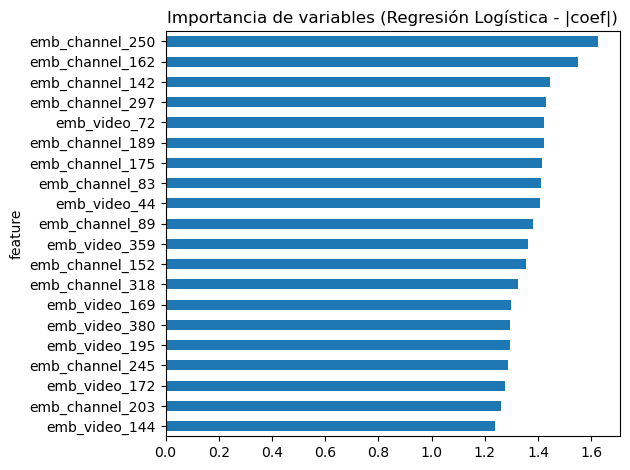

In [10]:
def _resolve_cols(cols, X_sample: pd.DataFrame):
    """Convierte 'cols' del ColumnTransformer a una lista de nombres de columnas."""
    if callable(cols):
        cols = cols(X_sample)
    if isinstance(cols, slice):
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and getattr(cols, "dtype", None) == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    """
    Devuelve nombres de salida de un ColumnTransformer 'ct' ya ajustado.
    - Usa get_feature_names_out cuando está disponible.
    - Para 'passthrough', devuelve las originales.
    - Para transformadores sin nombres, transforma una muestra y genera 'step_i'.
    """
    out = []
    for name, trans, cols in ct.transformers_:
        if trans == 'drop':
            continue

        cols_res = _resolve_cols(cols, X_sample)

        if hasattr(trans, "get_feature_names_out"):
            try:
                out.extend(list(trans.get_feature_names_out(cols_res)))
                continue
            except Exception:
                pass

        if trans == 'passthrough':
            out.extend(cols_res)
            continue

        # Transformador "opaco": inferimos nº columnas con una muestra
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            Xt = trans.transform(X_slice.iloc[:min(50, len(X_slice))])

        if hasattr(Xt, "toarray"):
            Xt = Xt.toarray()
        else:
            Xt = np.asarray(Xt)

        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])

    return np.array(out, dtype=object)

# ------------ ENTRENAR Y OBTENER IMPORTANCIAS (coeficientes) ------------
# 1) Entrena el pipeline (LogisticRegression como último paso)
pipeline_power.fit(X_train, y_train)

# 2) Modelo final
log_reg = pipeline_power.named_steps["model"]  # LogisticRegression(max_iter=1000)

# 3) Coeficientes (para binaria es un vector)
coefs = log_reg.coef_[0]

# 4) Nombres tras preprocesado (compat para embeddings/FunctionTransformer)
ct = pipeline_power.named_steps["preprocessing"]
X_sample = X_train.iloc[:50].copy()
try:
    feat_names = ct.get_feature_names_out()
except Exception:
    feat_names = get_ct_feature_names_compat(ct, X_sample)

# 5) DataFrame ordenado por magnitud
feat_imp = (pd.DataFrame({
                "feature": feat_names,
                "coefficient": coefs,
                "abs_coeff": np.abs(coefs)
            })
            .sort_values("abs_coeff", ascending=False))

print(feat_imp.head(20))

# 6) Gráfico top-20 por magnitud
plt.figure(figsize=(9,7))
feat_imp.head(20).plot(kind="barh", x="feature", y="abs_coeff", legend=False)
plt.gca().invert_yaxis()
plt.title("Importancia de variables (Regresión Logística - |coef|)")
plt.tight_layout()
plt.show()

ARBOL DECISION

In [11]:
tree_clf = DecisionTreeClassifier(
    criterion="log_loss",        # o "entropy"/"log_loss"
    max_depth=6,             # prueba 6–12 según tu data
    min_samples_leaf=18,     # sube/baja para controlar sobreajuste
    class_weight="balanced", # importante con tu desbalance
    random_state=42
)

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', tree_clf)
])

# ===== 2) Train / Test split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ===== 3) Entrenamiento =====
pipeline_power.fit(X_train, y_train)

# ===== 4) Predicción + métricas =====
y_pred = pipeline_power.predict(X_test)
y_proba = pipeline_power.predict_proba(X_test)[:, 1]

pipeline_power.fit(X_train, y_train)
predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

AUC train = 0.81
AUC test  = 0.77


DISTINCION VARIABLES. ARBOL DECISION

                 feature  importance
0       duration_minutes    0.404871
5    channel_video_count    0.123896
583      emb_channel_175    0.030633
430       emb_channel_22    0.027691
161        emb_video_137    0.026636
750      emb_channel_342    0.025968
228        emb_video_204    0.024300
384        emb_video_360    0.023778
490       emb_channel_82    0.023003
653      emb_channel_245    0.022791
518      emb_channel_110    0.022009
497       emb_channel_89    0.020663
551      emb_channel_143    0.020624
6       subscriber_count    0.020321
539      emb_channel_131    0.020180
58          emb_video_34    0.019337
664      emb_channel_256    0.018246
528      emb_channel_120    0.018059
338        emb_video_314    0.016886
141        emb_video_117    0.015957
493       emb_channel_85    0.014561
319        emb_video_295    0.013713
791      emb_channel_383    0.012386
210        emb_video_186    0.012235
329        emb_video_305    0.011807
39          emb_video_15    0.009449
2

<Figure size 900x700 with 0 Axes>

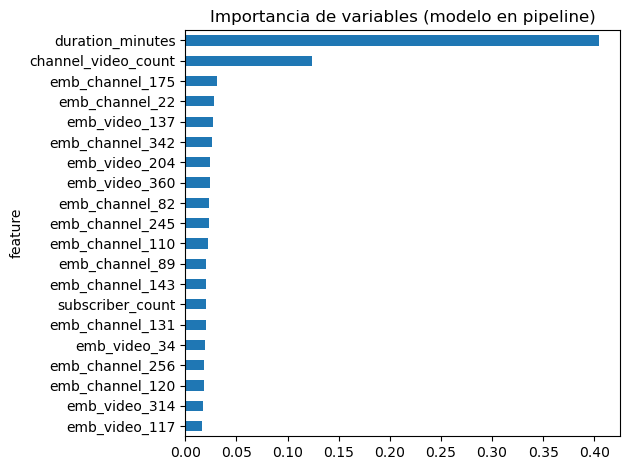

In [12]:
def _resolve_cols(cols, X_sample: pd.DataFrame):
    """Convierte 'cols' del ColumnTransformer a una lista de nombres de columnas."""
    if callable(cols):
        cols = cols(X_sample)
    if isinstance(cols, slice):
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        # índices enteros, máscara booleana o nombres
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and cols.dtype == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    # nombre único
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    """
    Devuelve nombres de salida de un ColumnTransformer 'ct' ya ajustado.
    - Usa get_feature_names_out cuando esté disponible.
    - Para 'passthrough', devuelve los nombres originales.
    - Para transformadores sin nombres, infiere n_cols transformando una muestra
      y genera nombres 'step_i'.
    """
    out = []

    # Recorre los transformadores ajustados: lista de (name, transformer, columns)
    for name, trans, cols in ct.transformers_:
        # Columnas descartadas
        if trans == 'drop':
            continue

        # Columnas a transformar (nombres)
        cols_res = _resolve_cols(cols, X_sample)

        # 1) Transformador con nombres propios
        if hasattr(trans, "get_feature_names_out"):
            try:
                feats = trans.get_feature_names_out(cols_res)
                out.extend(list(feats))
                continue
            except Exception:
                pass

        # 2) Passthrough
        if trans == 'passthrough':
            out.extend(cols_res)
            continue

        # 3) Caso opaco: inferir nº de columnas transformando una pequeña muestra
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            # algunos trafos requieren más de una fila
            Xt = trans.transform(X_slice.iloc[:min(50, len(X_slice))])

        # sparse -> denso para medir forma
        if hasattr(Xt, "toarray"):
            Xt = Xt.toarray()
        else:
            Xt = np.asarray(Xt)

        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])

    return np.array(out, dtype=object)
ct     = pipeline_power.named_steps["preprocessing"]
modelo = pipeline_power.named_steps["model"]  # RF / XGB ya entrenado

X_sample = X_train.iloc[:50].copy()
feature_names = get_ct_feature_names_compat(ct, X_sample)

importances = modelo.feature_importances_
assert len(importances) == len(feature_names), f"{len(importances)} != {len(feature_names)}"

feat_imp = (pd.DataFrame({"feature": feature_names, "importance": importances})
            .sort_values("importance", ascending=False))

print(feat_imp.head(30))

plt.figure(figsize=(9,7))
feat_imp.head(20).plot(kind="barh", x="feature", y="importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Importancia de variables (modelo en pipeline)")
plt.tight_layout()
plt.show()

RANDOM FORREST

In [13]:

param_dist = {'max_depth': [15,20,25],
              'min_samples_split': [20,30], 
              'min_samples_leaf': [4, 6]}
rf = RandomForestClassifier(random_state=42, 
                            class_weight='balanced')

modelo = GridSearchCV(rf, 
                      param_grid=param_dist,
                      scoring='roc_auc',
                      cv=5,
                      n_jobs=-1,
                      verbose=1)


pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', modelo)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
pipeline_power.fit(X_train, y_train)
predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

AUC train = 1.0
AUC test  = 0.85


DISTINCION VARIABLES. RANDOM FORREST

                 feature  importance
0       duration_minutes    0.042501
5    channel_video_count    0.011150
7          channel_views    0.008043
653      emb_channel_245    0.006030
343        emb_video_319    0.005946
..                   ...         ...
93          emb_video_69    0.001722
248        emb_video_224    0.001712
392        emb_video_368    0.001712
643      emb_channel_235    0.001712
745      emb_channel_337    0.001712

[90 rows x 2 columns]


<Figure size 900x700 with 0 Axes>

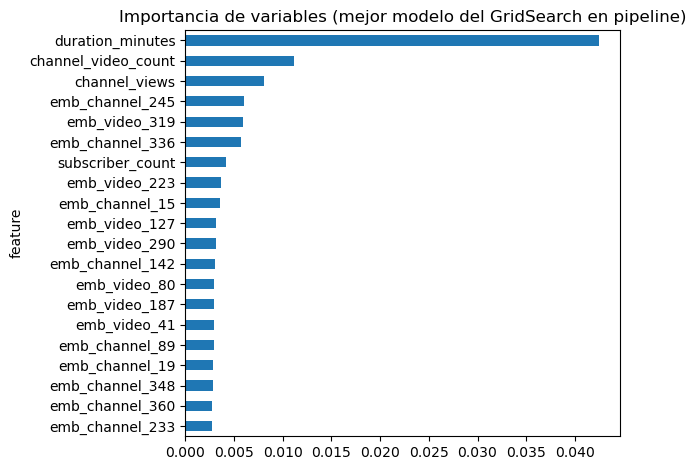

In [14]:
ct = pipeline_power.named_steps["preprocessing"]
model_step = pipeline_power.named_steps["model"]  # <- es un GridSearchCV

# Si es GridSearchCV, sacar el mejor estimador; si no, usar tal cual
final_model = model_step.best_estimator_ if hasattr(model_step, "best_estimator_") else model_step

# --- 2) Nombres de features a la salida del preprocesador ---
X_sample = X_train.iloc[:50].copy()
feature_names = get_ct_feature_names_compat(ct, X_sample)

# --- 3) Importancias (árboles: RF / XGBoost) ---
if hasattr(final_model, "feature_importances_"):
    importances = final_model.feature_importances_
else:
    raise AttributeError("El estimador final no expone 'feature_importances_'. "
                         "Si es un modelo lineal usa coeficientes; si no, usa permutation_importance.")

# Sanity check
assert len(importances) == len(feature_names), f"{len(importances)} != {len(feature_names)}"

feat_imp = (pd.DataFrame({"feature": feature_names, "importance": importances})
            .sort_values("importance", ascending=False))

print(feat_imp.head(90))

plt.figure(figsize=(9,7))
feat_imp.head(20).plot(kind="barh", x="feature", y="importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Importancia de variables (mejor modelo del GridSearch en pipeline)")
plt.tight_layout()
plt.show()

XGBOOST

In [15]:
xgb_model_2 = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
 #   scale_pos_weight=(len(y_tr)-sum(y_tr))/sum(y_tr),  # ajusta desbalance
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', xgb_model_2)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    stratify=y, 
    random_state=42
)

pipeline_power.fit(X_train, y_train)

predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)


AUC train = 1.0
AUC test  = 0.86


DISTINCION VARIABLE XGBOOST

                 feature  importance
0       duration_minutes    0.008300
753      emb_channel_345    0.006407
343        emb_video_319    0.006296
5    channel_video_count    0.005000
744      emb_channel_336    0.004402
7          channel_views    0.004314
653      emb_channel_245    0.004180
557      emb_channel_149    0.004038
21      category_id_27.0    0.003901
427       emb_channel_19    0.003892
486       emb_channel_78    0.003821
777      emb_channel_369    0.003628
768      emb_channel_360    0.003575
646      emb_channel_238    0.003521
771      emb_channel_363    0.003321
583      emb_channel_175    0.003307
611      emb_channel_203    0.003304
681      emb_channel_273    0.003288
629      emb_channel_221    0.003277
466       emb_channel_58    0.003248
709      emb_channel_301    0.003216
6       subscriber_count    0.003207
586      emb_channel_178    0.003073
782      emb_channel_374    0.003007
436       emb_channel_28    0.003004
247        emb_video_223    0.002986
6

<Figure size 900x700 with 0 Axes>

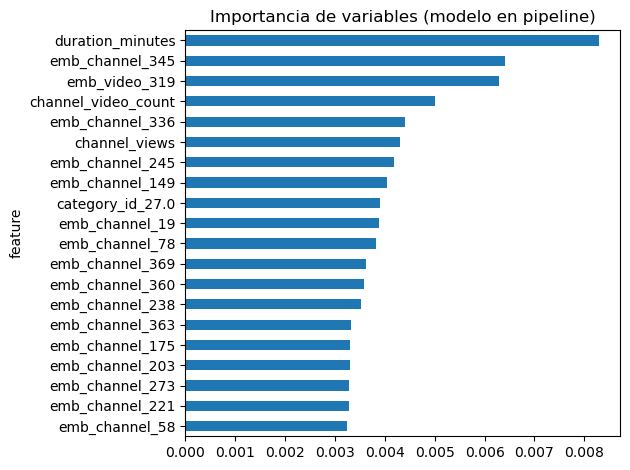

In [16]:
def _resolve_cols(cols, X_sample: pd.DataFrame):
    """Convierte 'cols' del ColumnTransformer a una lista de nombres de columnas."""
    if callable(cols):
        cols = cols(X_sample)
    if isinstance(cols, slice):
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        # índices enteros, máscara booleana o nombres
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and cols.dtype == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    # nombre único
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    """
    Devuelve nombres de salida de un ColumnTransformer 'ct' ya ajustado.
    - Usa get_feature_names_out cuando esté disponible.
    - Para 'passthrough', devuelve los nombres originales.
    - Para transformadores sin nombres, infiere n_cols transformando una muestra
      y genera nombres 'step_i'.
    """
    out = []

    # Recorre los transformadores ajustados: lista de (name, transformer, columns)
    for name, trans, cols in ct.transformers_:
        # Columnas descartadas
        if trans == 'drop':
            continue

        # Columnas a transformar (nombres)
        cols_res = _resolve_cols(cols, X_sample)

        # 1) Transformador con nombres propios
        if hasattr(trans, "get_feature_names_out"):
            try:
                feats = trans.get_feature_names_out(cols_res)
                out.extend(list(feats))
                continue
            except Exception:
                pass

        # 2) Passthrough
        if trans == 'passthrough':
            out.extend(cols_res)
            continue

        # 3) Caso opaco: inferir nº de columnas transformando una pequeña muestra
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            # algunos trafos requieren más de una fila
            Xt = trans.transform(X_slice.iloc[:min(50, len(X_slice))])

        # sparse -> denso para medir forma
        if hasattr(Xt, "toarray"):
            Xt = Xt.toarray()
        else:
            Xt = np.asarray(Xt)

        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])

    return np.array(out, dtype=object)
ct     = pipeline_power.named_steps["preprocessing"]
modelo = pipeline_power.named_steps["model"]  # RF / XGB ya entrenado

X_sample = X_train.iloc[:50].copy()
feature_names = get_ct_feature_names_compat(ct, X_sample)

importances = modelo.feature_importances_
assert len(importances) == len(feature_names), f"{len(importances)} != {len(feature_names)}"

feat_imp = (pd.DataFrame({"feature": feature_names, "importance": importances})
            .sort_values("importance", ascending=False))

print(feat_imp.head(30))

plt.figure(figsize=(9,7))
feat_imp.head(20).plot(kind="barh", x="feature", y="importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Importancia de variables (modelo en pipeline)")
plt.tight_layout()
plt.show()

Habría que bajar el AUC_TRAIN

In [17]:
pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', modelo)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

RED NEURONAL

In [18]:
# -----------------------
# Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
# -----------------------
# Utilidad: asegurar denso
# -----------------------
def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X

# -----------------------
# MLP con early stopping
# -----------------------
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   # empieza simple; prueba (64,) o (256,128,64)
    activation="relu",
    solver="adam",
    alpha=1e-4,                     # L2
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=42,
    verbose=False
)

# pipeline_power = Pipeline(steps=[
#     ("preprocessing", preprocessor),                  # StandardScaler + OneHotEncoder
#     ("to_dense", FunctionTransformer(to_dense)),      # por si queda sparse
#     ("model", mlp)
# ])
pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', mlp),
  #  ("to_dense", FunctionTransformer(to_dense))
])

# Ajuste de pesos por desbalance
#sw = compute_sample_weight(class_weight="balanced", y=y_train)

# Entrenamiento
pipeline_power.fit(X_train, y_train)#, model__sample_weight=sw)

# Evaluación (AUC)
def predict_and_get_auc(model, X_train, X_test, y_train, y_test):
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob  = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_train_prob); print("AUC train =", round(auc(fpr, tpr), 3))
    fpr, tpr, _ = roc_curve(y_test,  y_test_prob ); print("AUC test  =", round(auc(fpr, tpr), 3))

predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

AUC train = 0.957
AUC test  = 0.828


RED NEURONAL 2.0

In [19]:
def to_dense(Xm):
    return Xm.toarray() if sparse.issparse(Xm) else Xm

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.2,
    random_state=42
)


pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ("to_dense", FunctionTransformer(to_dense, accept_sparse=True)),
    ('model', mlp),
  #  ("to_dense", FunctionTransformer(to_dense))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

pipeline_power.fit(X_train, y_train)

predict_and_get_auc(pipeline_power, X_train, X_test, y_train, y_test)

AUC train = 0.957
AUC test  = 0.828


DISTINCIÓN VARIABLES RED NEURONAL

                   feature  importance
35       embedding_channel    0.093684
4         duration_minutes    0.090451
21           channel_views    0.090013
34         embedding_video    0.047047
16        subscriber_count    0.045422
20     channel_video_count    0.019815
23        channel_age_days    0.007710
8              category_id    0.007662
6         licensed_content    0.005125
7              has_caption    0.003339
31       comments_per_view    0.000000
32              text_video    0.000000
29        views_rate_video    0.000000
28       frecuencia_videos    0.000000
27  engagement_subscribers    0.000000
26              efficiency    0.000000
25         engagement_rate    0.000000
33            text_channel    0.000000
24             mostpopular    0.000000
22         channel_created    0.000000


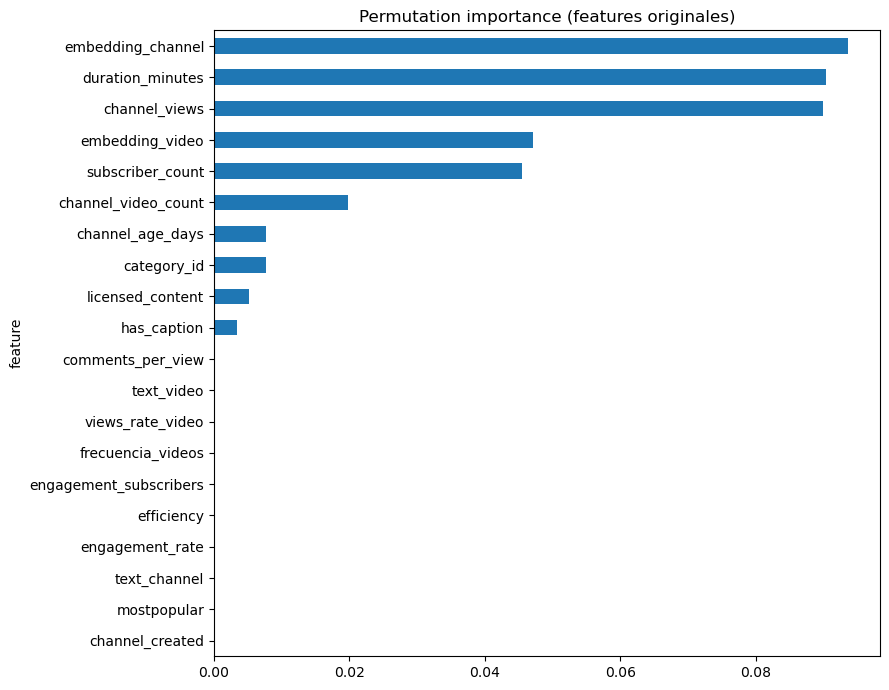

In [20]:
r = permutation_importance(
    estimator=pipeline_power,
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

# 2) Nombres: columnas originales (no las expandidas)
feat_names = list(X_test.columns)

imp_df = (pd.DataFrame({"feature": feat_names, "importance": r.importances_mean})
            .sort_values("importance", ascending=False))

print(imp_df.head(20))

imp_df.head(20).plot(kind="barh", x="feature", y="importance", legend=False, figsize=(9,7))
plt.gca().invert_yaxis(); plt.title("Permutation importance (features originales)")
plt.tight_layout(); plt.show()